# Libraries

In [1]:
import numpy as np
import numpy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from pyhull.delaunay import DelaunayTri

# My Libraries


In [2]:
from libraries.Spectrum import *
from libraries.MyPlot import *
import libraries.MyMath as mm

# Initial Data

In [3]:
start_wave = 400
end_wave = 700
data_size = 31
distance = (end_wave - start_wave) / (data_size - 1)

blue_sample_num = 7
yellow_sample_num = 7
red_sample_num = 7

maxRMS = 0.001
precise = 6
"""
Creating Wave lengths array for plots
Creating Example Data for checking plots
"""
# [400, 410, 420, ..., 700]
wave_length = mm.array_distance(400, distance, 700)

# [1, 1, 1, ..., 1]
example_data = mm.array_repeat(1, data_size)

"""
Start Getting Data From Excel file
"""
data = pd.read_excel("data/data.xls")

extract_data = pd.DataFrame(data, columns=["c"])
c = extract_data.to_numpy()
c = mm.cleanNaN(c)

R_red = []
for i in range(1, red_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["r" + str(i)])
    R_red.append(extract_data.to_numpy())

R_yellow = []
for i in range(1, yellow_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["y" + str(i)])
    R_yellow.append(extract_data.to_numpy())

R_blue = []
for i in range(1, blue_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["b" + str(i)])
    R_blue.append(extract_data.to_numpy())


extract_data = pd.DataFrame(data, columns=["Rsub"])
R_sub = extract_data.to_numpy()
k_sub = mm.applyFunction(R_sub, find_KOVERS)

extract_data = pd.DataFrame(data, columns=["Rstd"])
R_std = extract_data.to_numpy()
k_std = mm.applyFunction(R_std, find_KOVERS)

extract_data = pd.DataFrame(data, columns=["xbar"])
xbar = extract_data.to_numpy()

extract_data = pd.DataFrame(data, columns=["ybar"])
ybar = extract_data.to_numpy()

extract_data = pd.DataFrame(data, columns=["zbar"])
zbar = extract_data.to_numpy()

viewer = Viewer(xbar, ybar, zbar)

extract_data = pd.DataFrame(data, columns=["D65"])
E_D65 = extract_data.to_numpy()
light_source = LightSource(E_D65)

# Principal Component
munsell_size = 1269
munsell_R = []
data = pd.read_excel("data/Munsell400_10_700.xlsx")
for i in range(munsell_size):
    newdata = data[data.columns[i]]
    newdata = newdata.to_numpy()
    # newdata = np.array([newdata])
    munsell_R.append(newdata)
munsell_R = np.array(munsell_R).T

munsell_A = np.cov(munsell_R)
eigenValues, eigenVectors = linalg.eig(munsell_A)
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:, idx]

# print(eigenVectors)
print(eigenVectors[0:3])
print(eigenValues[0:3])

[[ 0.09483373 -0.11570643  0.15767145  0.13502343  0.04227553  0.01537553
   0.68705186  0.16506011 -0.52088994  0.21078248  0.04803513 -0.0775283
  -0.1955709  -0.07689112 -0.0691027   0.21392313  0.10883411 -0.02842454
  -0.00742043 -0.00944698 -0.01158433  0.01219628 -0.02104421  0.00348477
   0.01504926  0.00114911 -0.0121234   0.01790183 -0.00452232  0.00973035
   0.01003395]
 [ 0.1353475  -0.17545023  0.22671522  0.17301411  0.11678183 -0.02452445
   0.35124184  0.00246697  0.08137825 -0.13064751  0.01078028  0.14796422
   0.25835749  0.15818254  0.20203634 -0.63119229 -0.32125463  0.10558092
   0.0522483   0.03052858  0.07833556 -0.0358999   0.06553649 -0.01263544
  -0.05519987  0.03308766  0.08367907 -0.09461422  0.02463634 -0.05065704
  -0.0457393 ]
 [ 0.14416032 -0.19511855  0.23874847  0.1654432   0.14683691 -0.03530315
   0.12764635 -0.07413782  0.32175717 -0.2252548   0.02033118  0.16128194
   0.24043937  0.0154536   0.01312359  0.3270672   0.04688404 -0.17950324
   0.0788

# K OVER S for dyes

In [4]:
# initial object to find K OVER S for Blue Dye
BBB = Dye(blue_sample_num, data_size)
BBB.setR(R_blue)
BBB.setC(c)
BBB.setSub(R_sub)


# initial object to find K OVER S for Red Dye
RRR = Dye(red_sample_num, data_size)
RRR.setR(R_red)
RRR.setC(c)
RRR.setSub(R_sub)


# initial object to find K OVER S for Yellow Dye
YYY = Dye(yellow_sample_num, data_size)
YYY.setR(R_yellow)
YYY.setC(c)
YYY.setSub(R_sub)

blue_KOVERS = BBB.getKOVERS()
red_KOVERS = RRR.getKOVERS()
yellow_KOVERS = YYY.getKOVERS()

# Method 1 Spectrophotometric Matching

In [5]:
all_KOVERS = np.hstack((blue_KOVERS, red_KOVERS, yellow_KOVERS))
delta_KOVERS = mm.sum([k_std, -1 * k_sub])
C_First = findC1(all_KOVERS, delta_KOVERS)


First = Mixture(R_sub)
First.add(C_First[0], blue_KOVERS)
First.add(C_First[1], red_KOVERS)
First.add(C_First[2], yellow_KOVERS)
KOVERS_First = First.getKOVERS()
R_First = First.getR()

EST = Observation(light_source, viewer, R_First)
STD = Observation(light_source, viewer, R_std)
compare_1 = Compare(EST, STD)
RMS_First = compare_1.RMS()
DeltaE_First = compare_1.delta_E()

# Method 2 Colorimetric Matching

In [6]:
Data3 = findC2(STD, R_sub, C_First, all_KOVERS, maxRMS)
C_Last = Data3[0]
all_E = Data3[1]
num_tried = Data3[2]


Last = Mixture(R_sub)
Last.add(C_Last[0], blue_KOVERS)
Last.add(C_Last[1], red_KOVERS)
Last.add(C_Last[2], yellow_KOVERS)
KOVERS_Last = Last.getKOVERS()
R_Last = Last.getR()

ESTN = Observation(light_source, viewer, R_Last)
compare_2 = Compare(STD, ESTN)
RMS_Last = compare_2.RMS()
DeltaE_Last = compare_2.delta_E()

# SET R Substrate to 1

In [7]:
R_sub = np.array([mm.array_repeat(1, data_size)]).T

# Method 3 Interpolation using XYZ

In [8]:
pr = 10
Dis1 = np.linspace(0 * C_First[0], 1, pr)
Dis2 = np.linspace(0 * C_First[1], 1, pr)
Dis3 = np.linspace(0 * C_First[2], 1, pr)

XYZ_Lookup = []
C_Lookup = []

Mix = Mixture(R_sub)
for x in range(pr):
    for y in range(pr):
        for z in range(pr):
            Mix.clear()
            Mix.add(Dis1[x][0], blue_KOVERS)
            Mix.add(Dis2[y][0], red_KOVERS)
            Mix.add(Dis3[z][0], yellow_KOVERS)
            Temp = Observation(light_source, viewer, Mix.getR())
            XYZ_Lookup.append([Temp.getX(), Temp.getY(), Temp.getZ()])
            C_Lookup.append([Dis1[x][0], Dis2[y][0], Dis3[z][0]])

XYZ_Lookup = np.array(XYZ_Lookup)
C_Lookup = np.array(C_Lookup)

Temp = Observation(light_source, viewer, R_std)
Find = [Temp.getX(), Temp.getY(), Temp.getZ()]
calc = MyDelaunay(XYZ_Lookup)
res = calc.getResult(Find, C_Lookup)
C_Inter1 = res[0]

Mix.clear()
Mix.add(C_Inter1[0], blue_KOVERS)
Mix.add(C_Inter1[1], red_KOVERS)
Mix.add(C_Inter1[2], yellow_KOVERS)
R_Inter1 = Mix.getR()
Inter1 = Observation(light_source, viewer, Mix.getR())
STD = Observation(light_source, viewer, R_std)
compare_3 = Compare(Inter1, STD)
RMS_Inter1 = compare_3.RMS()
DeltaE_Inter1 = compare_3.delta_E()

print(C_Inter1)
print("RMS:", RMS_Inter1)
print("ΔE:", DeltaE_Inter1)

(p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
(p2,) = plt.plot(
    wave_length, R_Inter1, color="black", label="C Interpolation using XYZ"
)
lines = [p1, p2]
draw_R_style1(lines)

[0.23420132 0.27092521 0.0280852 ]
RMS: 0.2450273841718568
ΔE: 3.7231107982639418


# Method 4 Interpolation using R Principal Component 3D

[0.05843391 0.02063722 0.15973569]
[0.11111111 0.21893821 0.12018927]
RMS: 0.24728828616985385


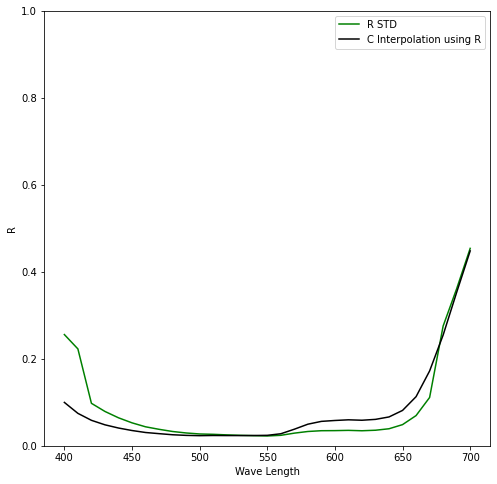

In [9]:
# Number of points
pr = 200

# Number of times to reduce dimension
dim = 3  # 3D

Dis1 = np.linspace(0, 1, pr)
Dis2 = np.linspace(0, 1, pr)
Dis3 = np.linspace(0, 1, pr)

R_Lookup = []
C_Lookup = []

Mix = Mixture(R_sub)
for x in range(pr):
    for y in range(pr):
        for z in range(pr):
            Mix.clear()
            Mix.add(Dis1[x], blue_KOVERS)
            Mix.add(Dis2[y], red_KOVERS)
            Mix.add(Dis3[z], yellow_KOVERS)
            R_Lookup.append(Mix.getR().T[0])
            C_Lookup.append([Dis1[x], Dis2[y], Dis3[z]])

R_Lookup = R_Lookup
R_Lookup = np.array(R_Lookup)
R_Lookup = mm.array_PC(R_Lookup, dim, eigenVectors)
# R_Lookup = mm.array_lift(R_Lookup)
# print(R_Lookup.shape)

C_Lookup = np.array(C_Lookup)
calc = MyDelaunay(R_Lookup, "Qt")

# Changing R_std
# R_std = np.array([munsell_R.T[55]]).T

# Finding
R_Find = R_std.T[0]
R_Find = mm.PC(R_Find, dim, eigenVectors)
# R_Find = mm.lift(R_Find)
print(R_Find)

"""
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
why = LinearNDInterpolator(R_Lookup,C_Lookup)
why = NearestNDInterpolator(R_Lookup,C_Lookup)
print("lib",why(R_Find))
"""
res = calc.getResult(R_Find, C_Lookup)
C_Inter2 = res[0]

Mix.clear()
Mix.add(C_Inter2[0], blue_KOVERS)
Mix.add(C_Inter2[1], red_KOVERS)
Mix.add(C_Inter2[2], yellow_KOVERS)
R_Inter2 = Mix.getR()
Inter2 = Observation(light_source, viewer, Mix.getR())
STD = Observation(light_source, viewer, R_std)
compare_4 = Compare(Inter2, STD)
RMS_Inter2 = compare_4.RMS()
DeltaE_Inter2 = compare_4.delta_E()

print(C_Inter2)
print("RMS:", RMS_Inter2)
print("ΔE:", DeltaE_Inter2)

(p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
(p2,) = plt.plot(wave_length, R_Inter2, color="black", label="C Interpolation using R")
lines = [p1, p2]
draw_R_style1(lines)

# Showing Results

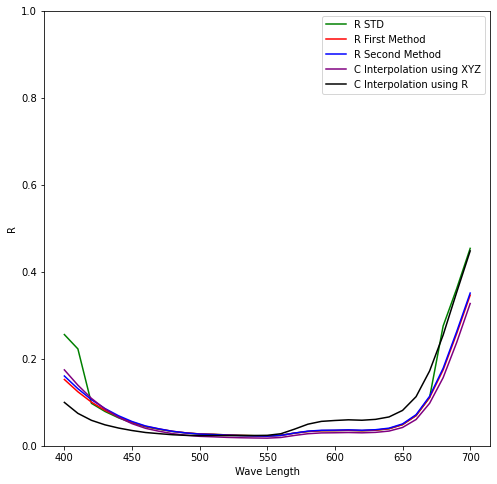

In [10]:
(p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
(p2,) = plt.plot(wave_length, R_First, color="red", label="R First Method")
(p3,) = plt.plot(wave_length, R_Last, color="blue", label="R Second Method")
(p4,) = plt.plot(
    wave_length, R_Inter1, color="purple", label="C Interpolation using XYZ"
)
(p5,) = plt.plot(wave_length, R_Inter2, color="black", label="C Interpolation using R")
# (p6,) = plt.plot(wave_length, R_sub, color='yellow', label="R SUB")
lines = [p1, p2, p3, p4, p5]
draw_R_style1(lines)

# Try Method 4 for different spectrum

In [11]:
print("Start")
munsell_size = 0
for i in range(munsell_size):
    # Changing R_std
    R_std = np.array([munsell_R.T[i]]).T

    # Finding
    R_Find = R_std.T[0]
    R_Find = mm.PC(R_Find, dim, eigenVectors)
    try:
        res = calc.getResult(R_Find, C_Lookup)
    except Exception:
        continue
        # C_CInter = np.array([0, 0, 0])

    C_CInter = res[0]

    Mix.clear()
    Mix.add(C_CInter[0], blue_KOVERS)
    Mix.add(C_CInter[1], red_KOVERS)
    Mix.add(C_CInter[2], yellow_KOVERS)
    R_CInter = Mix.getR()
    Inter = Observation(light_source, viewer, Mix.getR())
    STD = Observation(light_source, viewer, R_std)
    compare_4 = Compare(Inter, STD)
    RMS_CInter = compare_4.RMS()
    DeltaE_CInter = compare_4.delta_E()

    if RMS_CInter < 0.3:
        print(C_CInter)
        print("RMS: ", RMS_CInter)

        (p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
        (p2,) = plt.plot(
            wave_length, R_CInter, color="black", label="C Interpolation using R"
        )
        lines = [p1, p2]

        draw_R_style1(lines)
print("End")

Start
End
